In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import MyCode.utils as utils
import graphviz
from MyCode import relabeling
from MyCode.relabeling import Leaf

In [2]:
pd.set_option('max_columns', None)
FILE_NAME = "relab_Lawsuit"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("dataset_perso/Lawsuit.csv")
del df['ID']
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,0,0,7.4,9,3,77836,84612
1,1,1,0,0,6.7,10,2,69994,78497
2,1,1,0,0,8.1,6,1,62872,67756
3,1,1,1,1,5.1,27,3,155196,173220
4,1,1,0,0,7.0,10,3,89268,96099
...,...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,297174,323699
257,6,0,1,1,2.6,9,3,308081,339664
258,6,0,1,1,2.8,8,1,211269,241577
259,6,0,1,1,2.4,2,1,210801,233905


In [3]:
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Salary_mean
0,1,1,0,0,7.4,9,3,0.0
1,1,1,0,0,6.7,10,2,0.0
2,1,1,0,0,8.1,6,1,0.0
3,1,1,1,1,5.1,27,3,1.0
4,1,1,0,0,7.0,10,3,0.0
...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,1.0
257,6,0,1,1,2.6,9,3,1.0
258,6,0,1,1,2.8,8,1,1.0
259,6,0,1,1,2.4,2,1,1.0


In [4]:
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
df


,Gender,Clin,Cert,Salary_mean,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6
0,1,0,0,0.0,0,0,1,1,0,0,0,0,0
1,1,0,0,0.0,0,1,0,1,0,0,0,0,0
2,1,0,0,0.0,1,0,0,1,0,0,0,0,0
3,1,1,1,1.0,0,0,1,1,0,0,0,0,0
4,1,0,0,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0,1,1,1.0,0,1,0,0,0,0,0,0,1
257,0,1,1,1.0,0,0,1,0,0,0,0,0,1
258,0,1,1,1.0,1,0,0,0,0,0,0,0,1
259,0,1,1,1.0,1,0,0,0,0,0,0,0,1


In [5]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']
utils.discrimination(y, sensitive)

82 23 155 106


-0.31205112598904444

In [6]:
for i in range(0,len(df)):
    if df.at[i, "Gender"] == 1:
        df.at[i, "Gender"] = 0
    else:
        df.at[i, "Gender"] = 1
utils.discrimination(y, sensitive)

23 82 106 155


0.31205112598904444

In [7]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

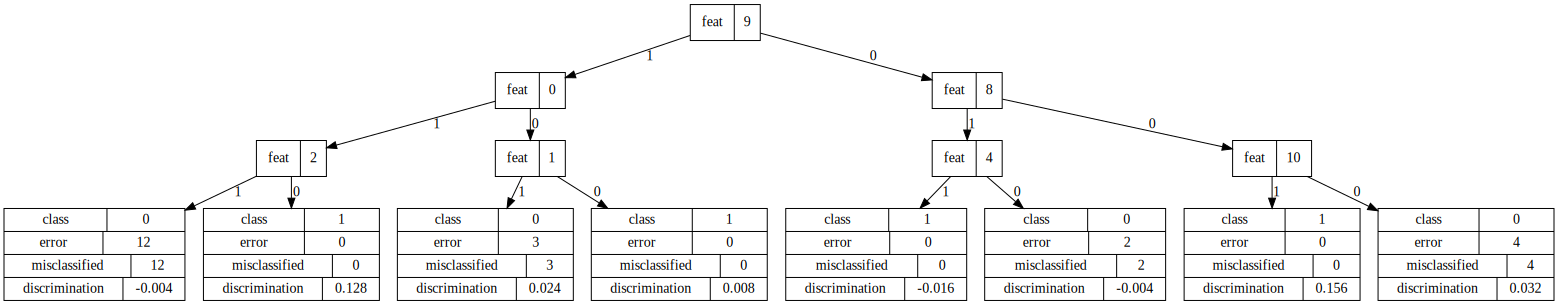

In [8]:
#clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=2,time_limit=600)
clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.misclassified(list(tids), y_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
utils.tree_upgrade(clf.tree_, y_train, sensitive_train)

dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)

In [9]:
import ast

y_pred_train = clf.predict(X_train)
discrimation_train = round(utils.discrimination(y_pred_train, sensitive_train), 4)
print(f"score: {clf.error_}")
print(f"acc: {round(accuracy_score(y_train, y_pred_train), 4)}")
print("Discrimination of classifier on train", discrimation_train)
print(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive', s=list(), bool=False))
print(utils.sum_elem_tree(clf.tree_, 'misclassified', s=list(), bool=False))

11 51 84 125
score: 21.0
acc: 0.8995
Discrimination of classifier on train 0.277
0.3256190476190477
21


In [10]:
from pprint import pprint

pprint(clf.tree_)

{'feat': 9,
 'left': {'feat': 0,
          'left': {'feat': 2,
                   'left': {'discrimination_additive': -0.0035238095238095193,
                            'error': 12.0,
                            'misclassified': 12,
                            'proba': [0.5714285714285714, 0.42857142857142855],
                            'transactions': [129,
                                             131,
                                             132,
                                             133,
                                             136,
                                             138,
                                             140,
                                             143,
                                             150,
                                             153,
                                             155,
                                             156,
                                             158,
                                    

In [11]:
result2 = pd.DataFrame(X_train, columns = X.columns)
result2["Class"] = y_train
result2["Sensitive"] = sensitive_train
result2["Pred"] = y_pred_train

In [12]:
relabeling.discrimination2(result2)

(0.0, 0.24401913875598086, 0.0, 0.05263157894736842, 0.4019138755980861, 0.5980861244019139)


0.277047619047619

In [13]:
relabeling.discrimination(y_train, y_train, sensitive_train)

0.32561904761904753

In [14]:
utils.discrimination(y_train, sensitive_train)

17 66 84 125


0.32561904761904764

In [15]:
relabeling.discrimination(y_train, y_pred_train, sensitive_train)

0.277047619047619

In [16]:
utils.discrimination(y_pred_train, sensitive_train)

11 51 84 125


0.277047619047619

In [17]:
leafs = list()
cnt = np.unique(sensitive, return_counts=True)[1]
relabeling.leafs_to_relabel(clf.tree_, y_train, sensitive_train, cnt[0], cnt[1], leafs, len(y_train))
#print(utils.sum_elem_tree(clf.tree_, "disc",  s=list(), bool=False))
pprint(clf.tree_)

{'feat': 9,
 'left': {'feat': 0,
          'left': {'feat': 2,
                   'left': {'discrimination_additive': -0.0035238095238095193,
                            'error': 12.0,
                            'misclassified': 12,
                            'proba': [0.5714285714285714, 0.42857142857142855],
                            'transactions': [129,
                                             131,
                                             132,
                                             133,
                                             136,
                                             138,
                                             140,
                                             143,
                                             150,
                                             153,
                                             155,
                                             156,
                                             158,
                                    

In [18]:
for leaf in leafs:
    print(leaf)
    print()

Path: ((9, 'left'), (0, 'left'), (2, 'left')) 
accuracy: -0.01913875598086124 
discrimination: -0.000275782135025496 
ratio: 0.01440961655508217 
contigency: 
[0.04784688995215311, 0.023923444976076555]
[0.028708133971291867, 0.03349282296650718]

Path: ((9, 'left'), (0, 'left'), (2, 'right')) 
accuracy: -0.12440191387559808 
discrimination: -0.0004985628460017415 
ratio: 0.004007678262090922 
contigency: 
[0.0, 0.019138755980861243]
[0.0, 0.10526315789473684]

Path: ((9, 'left'), (0, 'right'), (1, 'right')) 
accuracy: -0.004784688995215311 
discrimination: -3.086896125945362e-05 
ratio: 0.0064516129032258064 
contigency: 
[0.0, 0.0]
[0.0, 0.004784688995215311]

Path: ((9, 'right'), (8, 'left'), (4, 'right')) 
accuracy: -0.07177033492822968 
discrimination: -0.00024957263961652596 
ratio: 0.0034773787786569277 
contigency: 
[0.04784688995215311, 0.004784688995215311]
[0.03349282296650718, 0.004784688995215311]

Path: ((9, 'right'), (8, 'right'), (10, 'left')) 
accuracy: -0.153110047846

In [19]:
leafs_relab = relabeling.relab(clf.tree_, y_train, y_pred_train, sensitive_train, 0)
print()
for l in leafs_relab:
    print(l)
    print()

0.27669081795397577
0.27665254044201404
0.27603827751196164
0.27528958760537703
0.2749692412850307
0.27426201868307126

Path: ((9, 'left'), (0, 'left'), (2, 'left')) 
accuracy: -0.01913875598086124 
discrimination: -0.0003568010936431989 
ratio: 0.018642857142857145 
contigency: 
[0.04784688995215311, 0.023923444976076555]
[0.028708133971291867, 0.03349282296650718]

Path: ((9, 'right'), (8, 'right'), (10, 'left')) 
accuracy: -0.15311004784688997 
discrimination: -0.0007486899065846435 
ratio: 0.004889880952380952 
contigency: 
[0.0, 0.023923444976076555]
[0.0, 0.1291866028708134]

Path: ((9, 'left'), (0, 'right'), (1, 'right')) 
accuracy: -0.004784688995215311 
discrimination: -3.8277511961722486e-05 
ratio: 0.008 
contigency: 
[0.0, 0.0]
[0.0, 0.004784688995215311]

Path: ((9, 'right'), (8, 'left'), (4, 'right')) 
accuracy: -0.07177033492822968 
discrimination: -0.0003203463203463203 
ratio: 0.004463492063492063 
contigency: 
[0.04784688995215311, 0.004784688995215311]
[0.03349282296

In [20]:
#clf.tree_['left']['left']['right']['value']=1
#clf.tree_['right']['left']['left']['value']=0
#clf.tree_['right']['right']['left']['value']=0
clf.tree_

{'feat': 9,
 'left': {'feat': 0,
  'left': {'feat': 2,
   'left': {'value': 0,
    'error': 12.0,
    'transactions': [129,
     131,
     132,
     133,
     136,
     138,
     140,
     143,
     150,
     153,
     155,
     156,
     158,
     160,
     161,
     162,
     163,
     164,
     165,
     166,
     167,
     168,
     170,
     172,
     174,
     123,
     126,
     127],
    'proba': [0.5714285714285714, 0.42857142857142855],
    'discrimination_additive': -0.0035238095238095193,
    'misclassified': 12},
   'right': {'value': 1,
    'error': 0.0,
    'transactions': [128,
     130,
     135,
     137,
     139,
     141,
     142,
     146,
     149,
     151,
     152,
     154,
     157,
     159,
     169,
     171,
     113,
     115,
     117,
     118,
     119,
     120,
     121,
     122,
     124,
     125],
    'proba': [0, 1.0],
    'discrimination_additive': 0.12838095238095237,
    'misclassified': 0},
   'transactions': [128,
    129,
    130,
    1

In [21]:
print(len(leafs_relab))
for leaf in leafs_relab:
    relabeling.browse_and_relab(clf.tree_, list(leaf.path))
clf.tree_

6


{'feat': 9,
 'left': {'feat': 0,
  'left': {'feat': 2,
   'left': {'value': 1,
    'error': 12.0,
    'transactions': [129,
     131,
     132,
     133,
     136,
     138,
     140,
     143,
     150,
     153,
     155,
     156,
     158,
     160,
     161,
     162,
     163,
     164,
     165,
     166,
     167,
     168,
     170,
     172,
     174,
     123,
     126,
     127],
    'proba': [0.5714285714285714, 0.42857142857142855],
    'discrimination_additive': -0.0035238095238095193,
    'misclassified': 12},
   'right': {'value': 0,
    'error': 0.0,
    'transactions': [128,
     130,
     135,
     137,
     139,
     141,
     142,
     146,
     149,
     151,
     152,
     154,
     157,
     159,
     169,
     171,
     113,
     115,
     117,
     118,
     119,
     120,
     121,
     122,
     124,
     125],
    'proba': [0, 1.0],
    'discrimination_additive': 0.12838095238095237,
    'misclassified': 0},
   'transactions': [128,
    129,
    130,
    1

In [22]:
utils.tree_upgrade(clf.tree_, y_train, sensitive_train)

pprint(clf.tree_)

{'feat': 9,
 'left': {'feat': 0,
          'left': {'feat': 2,
                   'left': {'discrimination_additive': -0.0035238095238095193,
                            'error': 12.0,
                            'misclassified': 12,
                            'proba': [0.5714285714285714, 0.42857142857142855],
                            'transactions': [129,
                                             131,
                                             132,
                                             133,
                                             136,
                                             138,
                                             140,
                                             143,
                                             150,
                                             153,
                                             155,
                                             156,
                                             158,
                                    

In [23]:
y_pred_train = clf.predict(X_train)
discrimation_train = round(utils.discrimination(y_pred_train, sensitive_train), 4)
print(f"score: {clf.error_}")
print(f"acc: {round(accuracy_score(y_train, y_pred_train), 4)}")
print("Discrimination of classifier on train", discrimation_train)
print(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive', s=list(), bool=False))
print(utils.sum_elem_tree(clf.tree_, 'misclassified', s=list(), bool=False))

72 69 84 125
score: 21.0
acc: 0.1292
Discrimination of classifier on train -0.3051
0.3256190476190477
21
